In [1]:
# Initial imports
import numpy as np
import pandas as pd
from stockstats import StockDataFrame as sdf
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from pathlib import Path
import lib_copy
%matplotlib inline

In [2]:
load_dotenv()

Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8


True

In [3]:


df = lib_copy.fetch_ohlcv("TSLA")


In [4]:
def adding_boll_kelt_ewma_dataframe(dataframe):
    lib_copy.bollinger_band_generator(dataframe)
    lib_copy.keltner_channel(dataframe)
    lib_copy.ewma(dataframe)

    return dataframe

In [5]:
everything = adding_boll_kelt_ewma_dataframe(df)

In [6]:
# Looking for missing values
everything.isnull().sum().sum()

61

In [7]:
# Filling missing values with the previous ones
everything = df.dropna()
everything.head()

,open,high,low,close,volume,bollinger_band_middle,bollinger_band_std,bollinger_band_upper,bollinger_band_lower,close_-1_s,tr,tr_14_smma,atr,kcmid,kcup,kclo,EMA9,EMA21
2020-01-03 09:00:00-05:00,1872.79,1872.79,1872.79,1872.79,100,1884.8305,11.846847,1908.524195,1861.136805,1875.40,2.61,5.440821,5.440821,1884.8305,1890.271321,1879.389679,1877.560313,1881.099938
2020-01-03 09:15:00-05:00,1868.17,1868.17,1865.55,1865.55,971,1884.2835,12.487462,1909.258425,1859.308575,1872.79,7.24,5.607105,5.607105,1884.2835,1889.890605,1878.676395,1875.158250,1879.686308
2020-01-03 09:30:00-05:00,1865.01,1883.13,1865.01,1882.83,23393,1884.5600,12.385501,1909.331002,1859.788998,1865.55,18.12,6.739791,6.739791,1884.5600,1891.299791,1877.820209,1876.692600,1879.972098
2020-01-03 09:45:00-05:00,1882.74,1883.24,1873.41,1875.57,11946,1884.3040,12.521864,1909.347728,1859.260272,1882.83,9.83,7.014281,7.014281,1884.3040,1891.318281,1877.289719,1876.468080,1879.571907
2020-01-03 10:00:00-05:00,1872.91,1873.83,1869.98,1872.98,8779,1883.7285,12.774808,1909.278117,1858.178883,1875.57,5.59,6.889932,6.889932,1883.7285,1890.618432,1876.838568,1875.770464,1878.972643


In [8]:
response_data = lib_copy.signals_generator(everything)

response_data.index = response_data.index.date
final_df = response_data
final_df.head()

,open,high,low,close,volume,bollinger_band_middle,bollinger_band_std,bollinger_band_upper,bollinger_band_lower,close_-1_s,...,tr_14_smma,atr,kcmid,kcup,kclo,EMA9,EMA21,squeeze,crossover,target
2020-01-03,1872.79,1872.79,1872.79,1872.79,100,1884.8305,11.846847,1908.524195,1861.136805,1875.40,...,5.440821,5.440821,1884.8305,1890.271321,1879.389679,1877.560313,1881.099938,0.0,0.0,0.0
2020-01-03,1868.17,1868.17,1865.55,1865.55,971,1884.2835,12.487462,1909.258425,1859.308575,1872.79,...,5.607105,5.607105,1884.2835,1889.890605,1878.676395,1875.158250,1879.686308,0.0,0.0,0.0
2020-01-03,1865.01,1883.13,1865.01,1882.83,23393,1884.5600,12.385501,1909.331002,1859.788998,1865.55,...,6.739791,6.739791,1884.5600,1891.299791,1877.820209,1876.692600,1879.972098,0.0,0.0,0.0
2020-01-03,1882.74,1883.24,1873.41,1875.57,11946,1884.3040,12.521864,1909.347728,1859.260272,1882.83,...,7.014281,7.014281,1884.3040,1891.318281,1877.289719,1876.468080,1879.571907,0.0,0.0,0.0
2020-01-03,1872.91,1873.83,1869.98,1872.98,8779,1883.7285,12.774808,1909.278117,1858.178883,1875.57,...,6.889932,6.889932,1883.7285,1890.618432,1876.838568,1875.770464,1878.972643,0.0,0.0,0.0


In [9]:
X = final_df.iloc[:, 0:20].values
y = final_df.iloc[:, -1].values

X, y = np.array(X), np.array(y).reshape(-1,1)

In [10]:
print (f"X sample values:\n{X[:3]} \n")
print (f"X sample values:\n{y[:3]} \n")


X sample values:
[[1.87279000e+03 1.87279000e+03 1.87279000e+03 1.87279000e+03
  1.00000000e+02 1.88483050e+03 1.18468474e+01 1.90852419e+03
  1.86113681e+03 1.87540000e+03 2.61000000e+00 5.44082135e+00
  5.44082135e+00 1.88483050e+03 1.89027132e+03 1.87938968e+03
  1.87756031e+03 1.88109994e+03 0.00000000e+00 0.00000000e+00]
 [1.86817000e+03 1.86817000e+03 1.86555000e+03 1.86555000e+03
  9.71000000e+02 1.88428350e+03 1.24874625e+01 1.90925842e+03
  1.85930858e+03 1.87279000e+03 7.24000000e+00 5.60710485e+00
  5.60710485e+00 1.88428350e+03 1.88989060e+03 1.87867640e+03
  1.87515825e+03 1.87968631e+03 0.00000000e+00 0.00000000e+00]
 [1.86501000e+03 1.88313000e+03 1.86501000e+03 1.88283000e+03
  2.33930000e+04 1.88456000e+03 1.23855009e+01 1.90933100e+03
  1.85978900e+03 1.86555000e+03 1.81200000e+01 6.73979148e+00
  6.73979148e+00 1.88456000e+03 1.89129979e+03 1.87782021e+03
  1.87669260e+03 1.87997210e+03 0.00000000e+00 0.00000000e+00]] 

X sample values:
[[0.]
 [0.]
 [0.]] 



In [11]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [12]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [13]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.12594361]
  [0.12477404]
  [0.12838861]
  [0.12541629]
  [0.        ]
  [0.10887321]
  [0.10404451]
  [0.09570041]
  [0.1446202 ]
  [0.12678298]
  [0.01242561]
  [0.07316093]
  [0.07316093]
  [0.10887321]
  [0.10092469]
  [0.11659663]
  [0.11754904]
  [0.10682365]
  [0.        ]
  [0.        ]]

 [[0.12353006]
  [0.12236027]
  [0.12460147]
  [0.12162516]
  [0.00186098]
  [0.10857528]
  [0.10975017]
  [0.09609282]
  [0.14366617]
  [0.12541629]
  [0.03446798]
  [0.0773678 ]
  [0.0773678 ]
  [0.10857528]
  [0.10071616]
  [0.11621075]
  [0.11626464]
  [0.10605441]
  [0.        ]
  [0.        ]]

 [[0.12187923]
  [0.13017628]
  [0.12431901]
  [0.13067361]
  [0.04976796]
  [0.10872588]
  [0.10884204]
  [0.09613161]
  [0.14391687]
  [0.12162516]
  [0.08626517]
  [0.10602408]
  [0.10602408]
  [0.10872588]
  [0.10148802]
  [0.11574756]
  [0.11708507]
  [0.10620993]
  [0.        ]
  [0.        ]]] 

X_test sample values:
[[[0.85900564]
  [0.86258242]
  [0.86239202]
  

In [14]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [15]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [16]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [17]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 20, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [18]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
58/58 [==============================] - 2s 41ms/step - loss: 3.5542e-05
Epoch 2/10
58/58 [==============================] - 2s 39ms/step - loss: 1.6181e-05
Epoch 3/10
58/58 [==============================] - 2s 39ms/step - loss: 6.6653e-06
Epoch 4/10
58/58 [==============================] - 2s 38ms/step - loss: 2.3042e-06
Epoch 5/10
58/58 [==============================] - 2s 35ms/step - loss: 1.7869e-06
Epoch 6/10
58/58 [==============================] - 2s 37ms/step - loss: 1.3701e-06
Epoch 7/10
58/58 [==============================] - 2s 35ms/step - loss: 1.1955e-06
Epoch 8/10
58/58 [==============================] - 2s 37ms/step - loss: 1.0115e-06
Epoch 9/10
58/58 [==============================] - 2s 35ms/step - loss: 9.4301e-07
Epoch 10/10
58/58 [==============================] - 2s 36ms/step - loss: 8.4878e-07


In [19]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

2.7472397690075923e-09

In [20]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [21]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [22]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = final_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
2020-09-10,0.0,-0.000082
2020-09-10,0.0,-0.000082
2020-09-10,0.0,-0.000080
2020-09-10,0.0,-0.000080
2020-09-10,0.0,-0.000081


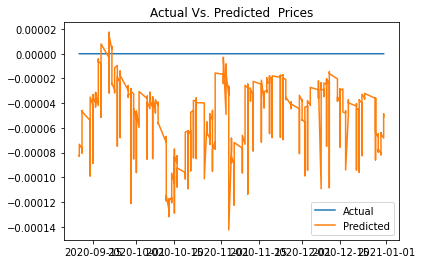

In [23]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted  Prices")

In [24]:
training_start = final_df.index.min().strftime(format = "%Y-%m-%d")
training_end = "2020-09-01"
testing_start = "2020-09-02"
testing_end = final_df.index.max().strftime(format= '%Y-%m-%d')


In [25]:
output = final_df["target"]
inputs = final_df.drop(columns=["target"])

X1 = inputs[training_start:training_end]
y1 = output[testing_start:testing_end]

TypeError: '<' not supported between instances of 'datetime.date' and 'str'

In [26]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train1 = X1[: split]
X_test1 = X1[split:]

y_train1 = y1[: split]
y_test1 = y1[split:]

NameError: name 'X1' is not defined